## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob
import re

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.stats import gaussian_kde
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp, to_numpy
from bilby.hyper.model import Model

from priors import *

xp = gwpop.cupy_utils.xp

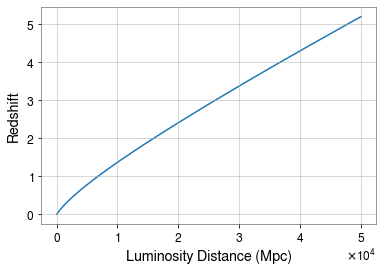

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1 * cost1 + a2 * q * cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)

luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

## Selection Effects

In [ ]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**-2.35 * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    
    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

## Posteriors

#### GWTC - 1 

In [17]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

posteriors = list()
events = list()
i = 0

file = '../../GWTC-1/GWTC-1_sample_release/{}_GWTC-1.hdf5'

events1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 
          'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823']

for e in events1:
    print(i, e)
    i = i+1
    events.append(e)
    _posterior = pd.DataFrame()
    with h5py.File(file.format(e), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriors.append(_posterior)
    
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    posterior['chi_eff'] = chieff(posterior['a_1'], posterior['a_2'], posterior['mass_ratio'],
                                  posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    posterior['chi_p'] = chiP(posterior['a_1'], posterior['a_2'],
                              posterior['mass_ratio'], posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    del posterior["mass_1_det"]
    del posterior["mass_2_det"]

0 GW150914
1 GW151012
2 GW151226
3 GW170104
4 GW170608
5 GW170729
6 GW170809
7 GW170814
8 GW170818
9 GW170823


#### GWTC - 2

In [4]:
parameter_translator = dict(
    mass_1 = 'mass_1_source',
    mass_2 = 'mass_2_source',
    mass_ratio = 'mass_ratio',
    luminosity_distance = 'luminosity_distance',
    a_1 = 'a_1',
    a_2 = 'a_2',
    cos_tilt_1 = 'cos_tilt_1',
    cos_tilt_2 = 'cos_tilt_2', 
    chi_eff = 'chi_eff', 
    chi_p = 'chi_p', 
    redshift = 'redshift')

# 44 events excluding
# S190425z.h5
# S190426c.h5
# S190719an.h5
# S190814bv.h5
# S190909w.h5

events2 = ['S190408an.h5', 'S190412m.h5', 'S190413ac.h5', 
          'S190413i.h5', 'S190421ar.h5', 'S190424ao.h5', 
          'S190503bf.h5', 'S190512at.h5', 'S190513bm.h5',
          'S190514n.h5', 'S190517h.h5', 'S190519bj.h5',
          'S190521g.h5', 'S190521r.h5', 'S190527w.h5',
          'S190602aq.h5', 'S190620e.h5', 'S190630ag.h5',
          'S190701ah.h5', 'S190706ai.h5', 'S190707q.h5',
          'S190708ap.h5', 'S190720a.h5', 'S190727h.h5',
          'S190728q.h5', 'S190731aa.h5', 'S190803e.h5',
          'S190828j.h5', 'S190828l.h5', 'S190910s.h5', 
          'S190915ak.h5', 'S190924h.h5', 'S190929d.h5',
          'S190930s.h5']

file = '../../GWTC-2/GWTC-2_sample_release/{}'

for e in events2:
    print(i, e)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(e), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["PrecessingSpinIMRHM"]['posterior_samples'][gwtc_key]
    posteriors.append(_posterior)
    e = e[:-3]
    events.append(e)

10 S190408an.h5
11 S190412m.h5
12 S190413ac.h5
13 S190413i.h5
14 S190421ar.h5
15 S190424ao.h5
16 S190503bf.h5
17 S190512at.h5
18 S190513bm.h5
19 S190514n.h5
20 S190517h.h5
21 S190519bj.h5
22 S190521g.h5
23 S190521r.h5
24 S190527w.h5
25 S190602aq.h5
26 S190620e.h5
27 S190630ag.h5
28 S190701ah.h5
29 S190706ai.h5
30 S190707q.h5
31 S190708ap.h5
32 S190720a.h5
33 S190727h.h5
34 S190728q.h5
35 S190731aa.h5
36 S190803e.h5
37 S190828j.h5
38 S190828l.h5
39 S190910s.h5
40 S190915ak.h5
41 S190924h.h5
42 S190929d.h5
43 S190930s.h5


In [5]:
print(events, len(events))

['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar', 'S190424ao', 'S190503bf', 'S190512at', 'S190513bm', 'S190514n', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e', 'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap', 'S190720a', 'S190727h', 'S190728q', 'S190731aa', 'S190803e', 'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h', 'S190929d', 'S190930s'] 44


## Prior Calculation

In [6]:
def joint_prior_from_isotropic_spins(q,aMax,xeffs,xps,ndraws=10000,bw_method='scott'):

    # Convert to arrays for safety
    xeffs = np.reshape(xeffs,-1)
    xps = np.reshape(xps,-1)
    q = np.reshape(q, -1)
    
    # Compute marginal prior on xeff, conditional prior on xp, and multiply to get joint prior!
    p_chi_eff = np.array([chi_effective_prior_from_isotropic_spins(q[i],aMax,xeffs[i]) for i in range(len(xeffs))])
    p_chi_eff = np.reshape(p_chi_eff, -1)
    
    p_chi_p_given_chi_eff = np.array([chi_p_prior_given_chi_eff_q(q[i],aMax,xeffs[i],xps[i],
                                                                  ndraws,bw_method) for i in range(len(xeffs))])
    
    joint_p_chi_p_chi_eff = p_chi_eff*p_chi_p_given_chi_eff

    return joint_p_chi_p_chi_eff

In [7]:
i = 0
for posterior in posteriors:
    print(i)
    x = posterior["chi_eff"]
    y = posterior["chi_p"]
    q = posterior["mass_ratio"]
    
    posterior["joint_prior"] = joint_prior_from_isotropic_spins(q, 1, x, y)
    
    posterior.to_csv("../processed_samples/OverallPosteriors/{}.csv".format(events[i]), index = False)
    i = i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [3]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()

i = 0
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

0 ../processed_samples/OverallPosteriors/S190408an.csv
1 ../processed_samples/OverallPosteriors/GW170823.csv
2 ../processed_samples/OverallPosteriors/S190521g.csv
3 ../processed_samples/OverallPosteriors/S190708ap.csv
4 ../processed_samples/OverallPosteriors/GW170818.csv
5 ../processed_samples/OverallPosteriors/S190521r.csv
6 ../processed_samples/OverallPosteriors/S190514n.csv
7 ../processed_samples/OverallPosteriors/S190513bm.csv
8 ../processed_samples/OverallPosteriors/S190929d.csv
9 ../processed_samples/OverallPosteriors/S190720a.csv
10 ../processed_samples/OverallPosteriors/S190620e.csv
11 ../processed_samples/OverallPosteriors/S190915ak.csv
12 ../processed_samples/OverallPosteriors/GW170809.csv
13 ../processed_samples/OverallPosteriors/S190803e.csv
14 ../processed_samples/OverallPosteriors/GW170608.csv
15 ../processed_samples/OverallPosteriors/S190512at.csv
16 ../processed_samples/OverallPosteriors/S190707q.csv
17 ../processed_samples/OverallPosteriors/GW150914.csv
18 ../processed

In [6]:
# VT Function


def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    # Calculate prior
    
#     pm1 = m1**-2.35
#     pq = q**2
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])
    
#     prior = np.array(pm1 * pq * pchieff)
    prior = np.array(pchieff)
    
    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        prior = xp.asarray(prior[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff])
    vt_func = injection_resampling_vt
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

18:28 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


### Hyper prior model

In [7]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"]

In [8]:
priors = PriorDict()

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [9]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [10]:
for ii in range(10):
    likelihood.parameters.update(priors.sample())
    print(likelihood.parameters)
    print(likelihood.log_likelihood_ratio())

{'mu_chi_eff': 0.6600592156119238, 'sigma_chi_eff': 0.40593336828292564, 'mu_chi_p': 0.5539281612513849, 'sigma_chi_p': 0.7203595574032347, 'spin_covariance': -0.41068441092998487}
280.75274472529986
{'mu_chi_eff': 0.5132079750163896, 'sigma_chi_eff': 0.5244261342191987, 'mu_chi_p': 0.4989999946902298, 'sigma_chi_p': 0.8687474330659075, 'spin_covariance': -0.018289652997920403}
289.12532993187625
{'mu_chi_eff': -0.7366068358056377, 'sigma_chi_eff': 0.7373436490492545, 'mu_chi_p': 0.1783284563399203, 'sigma_chi_p': 0.6321026906121631, 'spin_covariance': -0.6352471585006612}
300.03413708033753
{'mu_chi_eff': 0.5298042479082301, 'sigma_chi_eff': 0.29815850680823336, 'mu_chi_p': 0.29600117989076186, 'sigma_chi_p': 0.49968224028607594, 'spin_covariance': 0.3190789152007052}
289.87565167765564
{'mu_chi_eff': -0.2482281145489429, 'sigma_chi_eff': 0.6206064430617138, 'mu_chi_p': 0.09417739315967326, 'sigma_chi_p': 0.9521171612784348, 'spin_covariance': 0.16463372582261493}
307.5290085457519
{'

In [11]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin_vt", outdir = "gaussian_spin_vt", clean = True)

18:29 bilby INFO    : Running for label 'gaussian_spin_vt', output will be saved to 'gaussian_spin_vt'
18:29 bilby INFO    : Search parameters:
18:29 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
18:29 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
18:29 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
18:29 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
18:29 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
18:29 bilby INFO    : Single likelihood evaluation took 4.010e-03 s


0it [00:00, ?it/s]

18:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f2560118e20>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:29 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:29 bilby INFO    : Using dynesty version 1.0.1
18:29 bilby INFO    : Using the bilby-implemented rwalk sam

19:49 bilby INFO    : Sampling time: 1:19:57.126695
19:49 bilby INFO    : Summary of results:
nsamples: 14214
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.132
ln_bayes_factor: 336.903 +/-  0.132



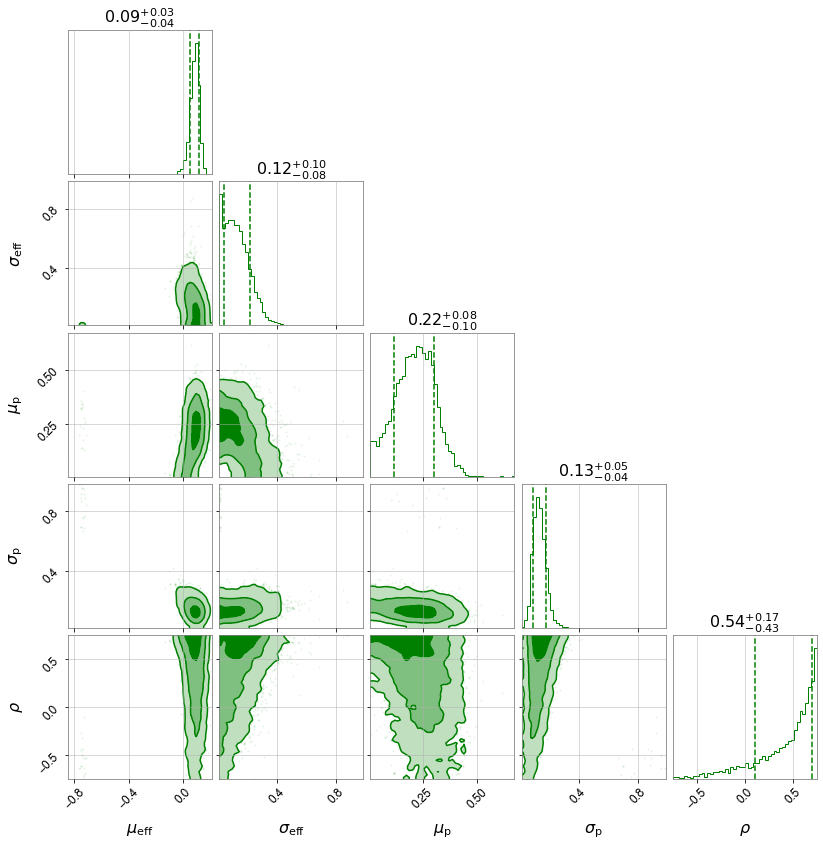

In [12]:
# Only using spin model with selection effects

result.plot_corner(color = 'g')

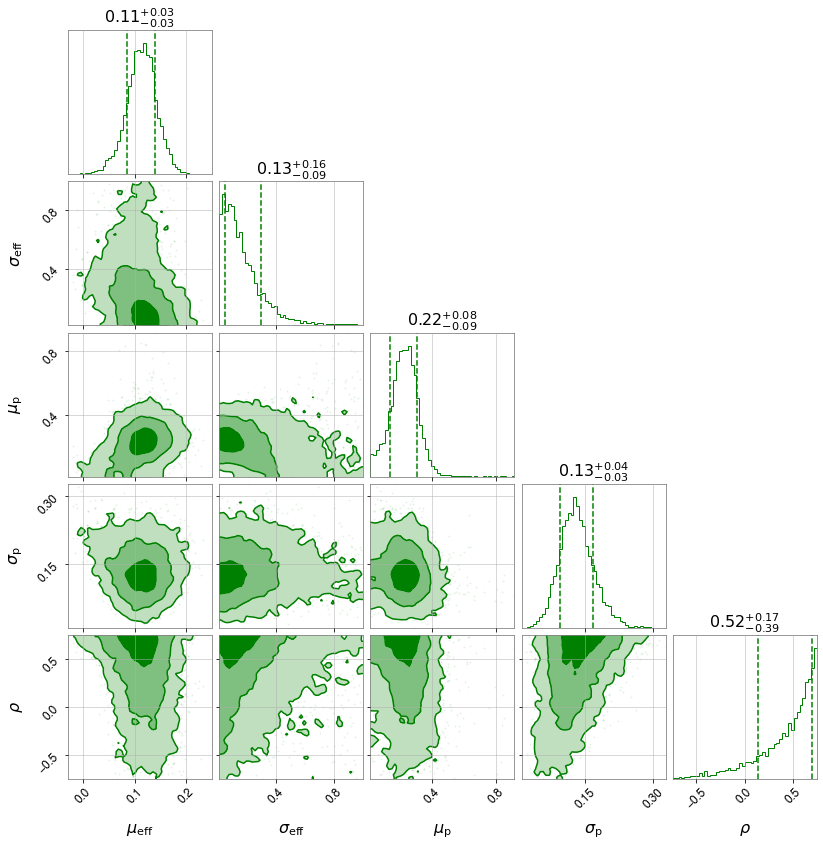

In [11]:
# Only using spin model without selection effects

result_joint.plot_corner(color = 'g')

### Using mass, redshift and spin models

In [23]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))

PRIOR_VOLUME = (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2

for posterior in posteriors:
    posterior["prior"] =  (posterior["joint_prior"]*posterior["mass_1"]*(1+posterior["redshift"])**2)/PRIOR_VOLUME

In [24]:
model1 = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio,
                                 redshift.PowerLawRedshift()])

In [25]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5.0
priors["mmax"] = 75.0

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

# redshift
priors["lamb"] = 2.7

In [26]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model1,
                                                    selection_function = selection_function)

In [27]:
for ii in range(10):
    likelihood.parameters.update(priors.sample())
    print(likelihood.parameters)
    print(likelihood.log_likelihood_ratio())

{'alpha': -2.2, 'beta': 1.3, 'mmin': 5.0, 'mmax': 75.0, 'mu_chi_eff': 0.9151190292833455, 'sigma_chi_eff': 0.643373821159915, 'mu_chi_p': 0.9230091947176625, 'sigma_chi_p': 0.6713819562367721, 'spin_covariance': -0.21333959784801604, 'lamb': 2.7}
-303.2106429993947
{'alpha': -2.2, 'beta': 1.3, 'mmin': 5.0, 'mmax': 75.0, 'mu_chi_eff': -0.38514888781658496, 'sigma_chi_eff': 0.5764477283858984, 'mu_chi_p': 0.5817045552824512, 'sigma_chi_p': 0.2800200990281894, 'spin_covariance': 0.6589444777914881, 'lamb': 2.7}
-297.13601666138396
{'alpha': -2.2, 'beta': 1.3, 'mmin': 5.0, 'mmax': 75.0, 'mu_chi_eff': -0.9507439366175423, 'sigma_chi_eff': 0.9500624187328806, 'mu_chi_p': 0.994233031300497, 'sigma_chi_p': 0.4760821956038681, 'spin_covariance': 0.39302133302384856, 'lamb': 2.7}
-1.7976931348623157e+308
{'alpha': -2.2, 'beta': 1.3, 'mmin': 5.0, 'mmax': 75.0, 'mu_chi_eff': -0.3966468188204857, 'sigma_chi_eff': 0.5755427013659528, 'mu_chi_p': 0.6133042918069195, 'sigma_chi_p': 0.05754731411617995

In [28]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "gaussian_spin_mass_vt", 
                           outdir = "gaussian_spin_mass_vt", clean = True)

05:46 bilby INFO    : Running for label 'gaussian_spin_mass_vt', output will be saved to 'gaussian_spin_mass_vt'
05:46 bilby INFO    : Search parameters:
05:46 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
05:46 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
05:46 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_\\mathrm{p}$', unit=None, boundary=None)
05:46 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{p}$', unit=None, boundary=None)
05:46 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
05:46 bilby INFO    :   alpha = -2.2
05:46 bilby INFO    :   beta = 1.3
05:46 bilby INFO    :   mmin = 5.0
05:46 bilby INFO    :   mm

0it [00:00, ?it/s]

05:46 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f39bad8d190>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
05:46 bilby INFO    : Checkpoint every check_point_delta_t = 600s
05:46 bilby INFO    : Using dynesty version 1.0.1
05:46 bilby INFO    : Using the bilby-implemented rwalk sam

10:48 bilby INFO    : Sampling time: 5:01:07.836613
10:49 bilby INFO    : Summary of results:
nsamples: 32386
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.227
ln_bayes_factor: 51.409 +/-  0.227



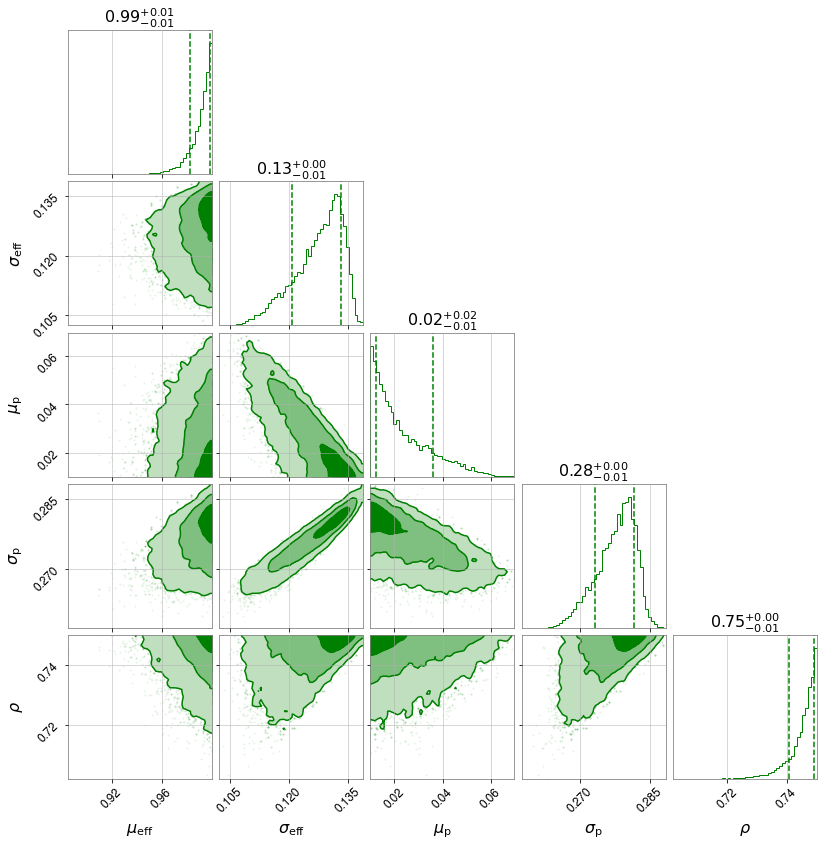

In [29]:
# Gaussian Spin + Mass model with selection effects

result.plot_corner(color = 'g')

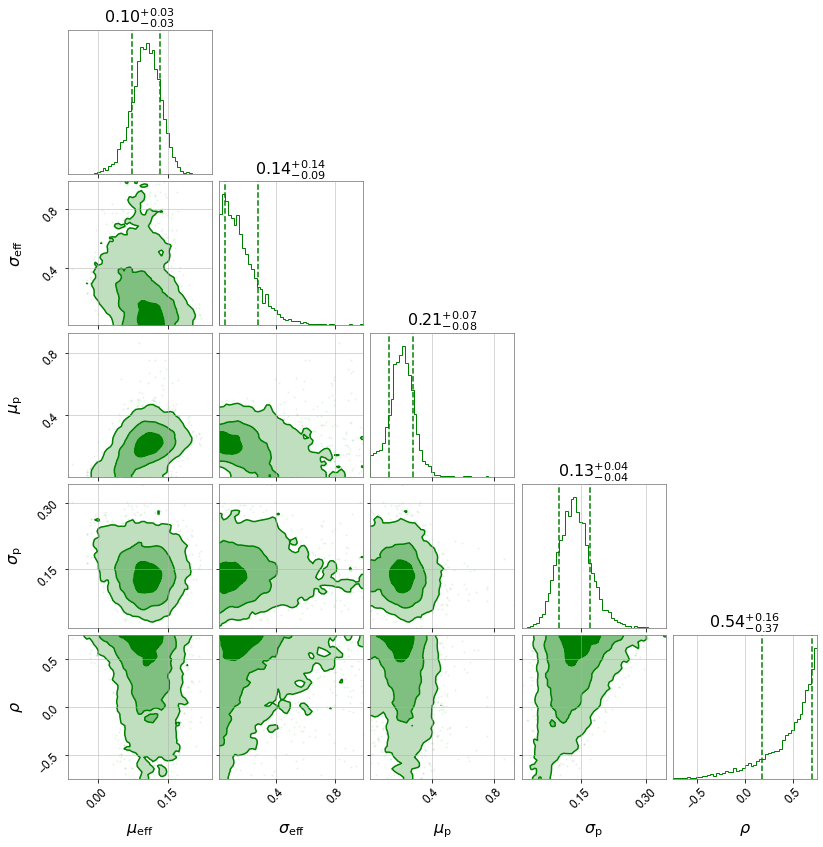

In [22]:
# Gaussian Spin + Mass model without selection effects

result.plot_corner(color = 'g')